In [1]:
import pandas as pd 
import backtesting 
from backtesting import Backtest, Strategy 
import matplotlib.pyplot as plt
import datetime

In [2]:
minute_candles = pd.read_csv('markov/vol_cross_btc.csv')

In [3]:
spare_minute_candles = minute_candles.copy()


In [4]:
spare_minute_candles['datetime'] = pd.to_datetime(spare_minute_candles['datetime'])
spare_minute_candles = spare_minute_candles.set_index('datetime')

In [13]:
df = pd.read_csv('data/BTCUSDT.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

In [15]:
from helpers import create_psar_indicator_before_bt
ASSET = "BTCUSDT"

minute_candles = df.copy()

# minute_candles["datetime"] = pd.to_datetime(minute_candles["datetime"])
# minute_candles = minute_candles.set_index("datetime")
psar_settings = {"BTCUSDT": {"start":.04, 'increment': .03, 'maximum': .12}, "ETHUSDT": {"start":.022, 'increment': .018, 'maximum': .18}}

signals = create_psar_indicator_before_bt(
    minute_candles, start=psar_settings[ASSET]['start'], increment=psar_settings[ASSET]['increment'], maximum=psar_settings[ASSET]['maximum']
)

df_ = pd.DataFrame(signals)
df_ = df_.set_index("datetime")

# df['cross'] = spare_minute_candles['cross']

Signal Calculation: 5.823960542678833


In [16]:
df_ = df_[['Signal']]

df_.to_csv('psar_btc_signals.csv')

In [6]:

# combination = spare_minute_candles.copy()
# combination['datetime'] = pd.to_datetime(combination['datetime'])
# combination = combination.set_index('datetime')

print(df)
# combination['cross'] = df['cross']
# print(combination)

                               Open      High       Low     Close  Signal  \
datetime                                                                    
2023-01-02 08:15:00+00:00  16747.16  16760.00  16743.78  16757.80     0.0   
2023-01-02 08:16:00+00:00  16758.47  16760.99  16754.99  16757.10     0.0   
2023-01-02 08:17:00+00:00  16757.42  16772.01  16752.83  16759.29     0.0   
2023-01-02 08:18:00+00:00  16760.07  16760.37  16751.52  16752.22     0.0   
2023-01-02 08:19:00+00:00  16752.22  16752.75  16737.29  16740.27     0.0   
...                             ...       ...       ...       ...     ...   
2023-11-09 17:08:00+00:00  36401.09  36407.51  36340.93  36340.93     0.0   
2023-11-09 17:09:00+00:00  36340.94  36416.13  36340.93  36412.35     0.0   
2023-11-09 17:10:00+00:00  36412.36  36412.36  36353.80  36400.04     0.0   
2023-11-09 17:11:00+00:00  36400.04  36411.10  36320.00  36326.99     0.0   
2023-11-09 17:12:00+00:00  36326.99  36328.17  36268.00  36268.01     0.0   

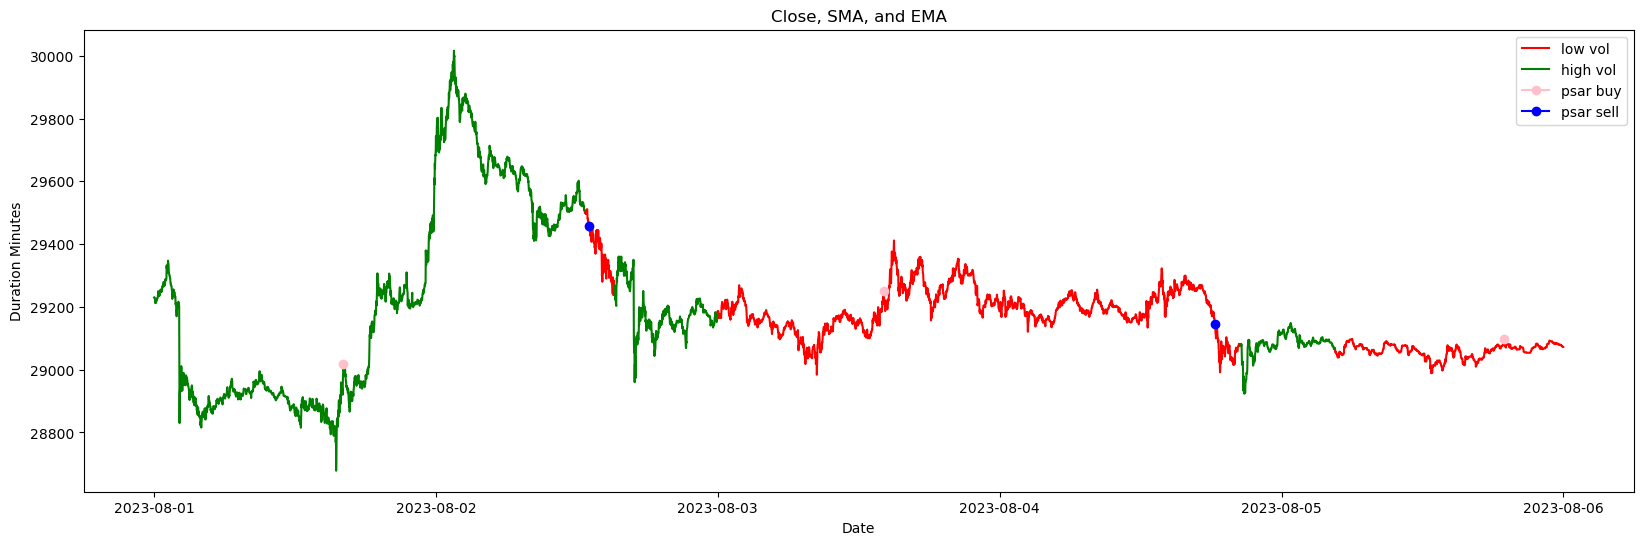

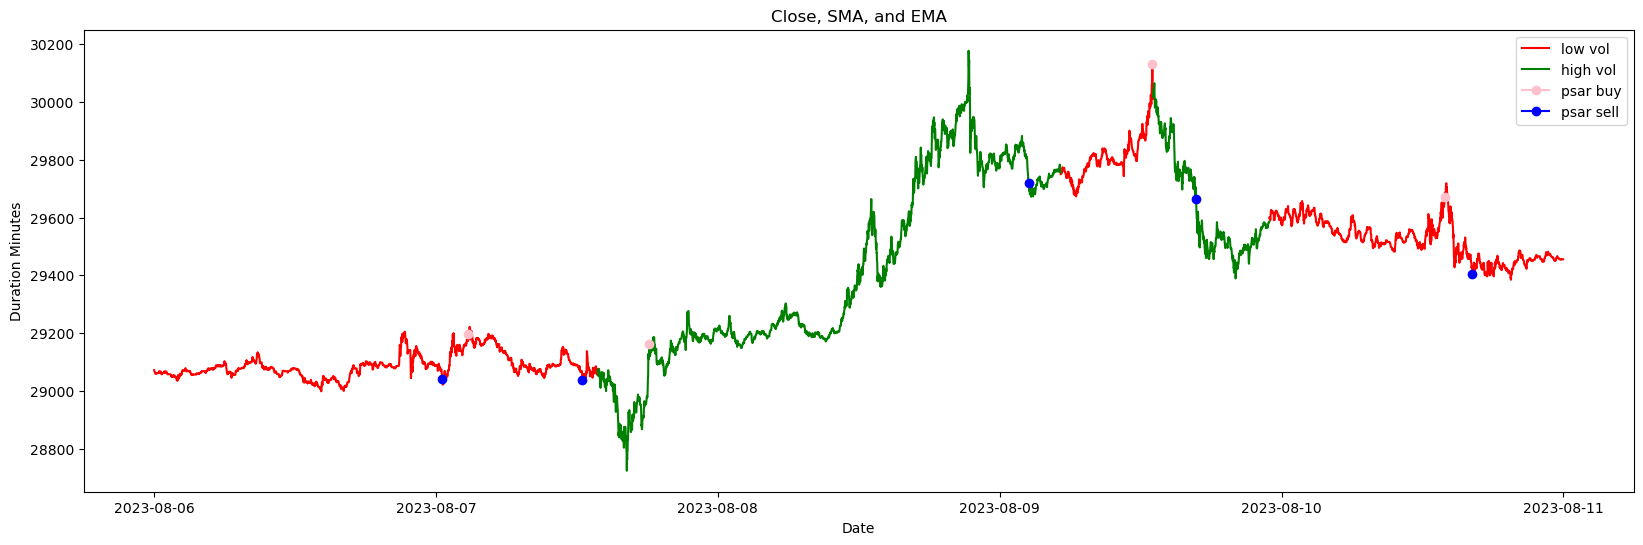

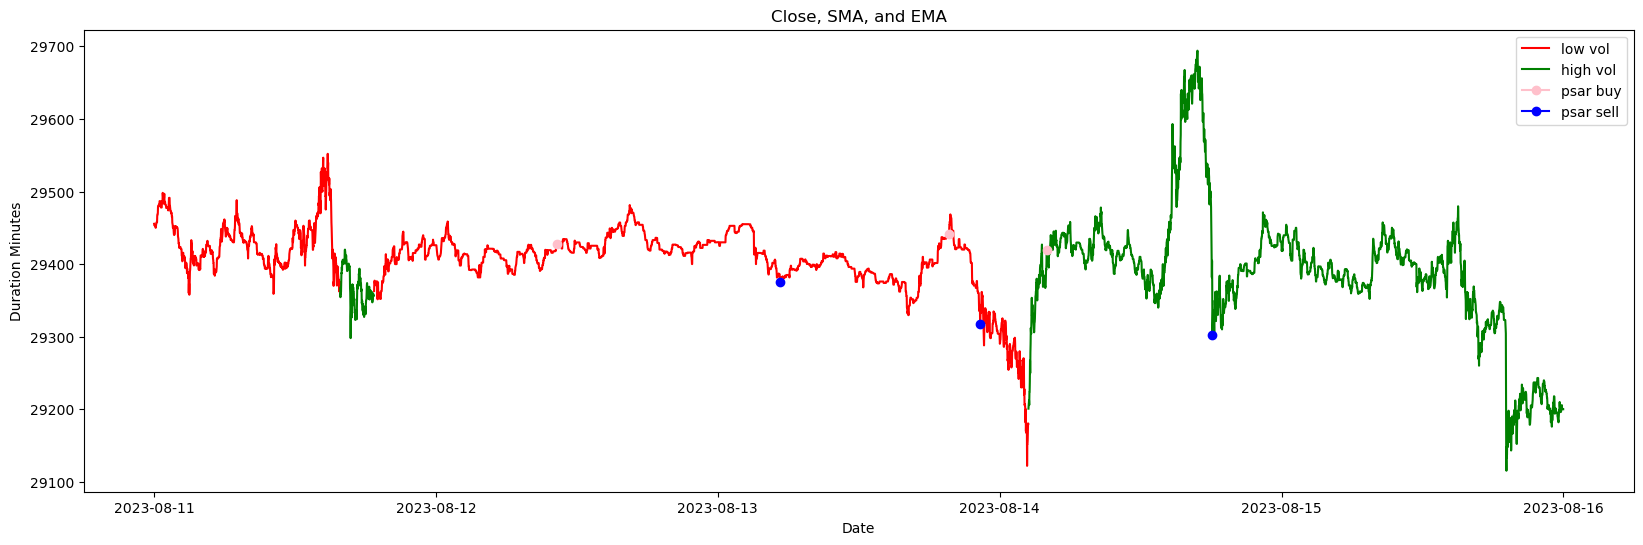

In [59]:

import numpy as np

for i in range(3):
    start = f'2023-08-{(i*5)+1}'
    end = f'2023-08-{(i+1)*5}'

    plot_sample = df.loc[start:end].copy()

    # print(plot_sample.to_markdown())
    


    plot_sample['bullish'] = np.where(plot_sample['cross'] == 1, None, plot_sample['Close'])
    plot_sample['bearish'] = np.where(plot_sample['cross'] == -1, None, plot_sample['Close'])

    plot_sample['psar buy'] = np.where(plot_sample['Signal'] != 1, None, plot_sample['Close'])
    plot_sample['psar sell'] = np.where(plot_sample['Signal'] != -1, None, plot_sample['Close'])

    # print(plot_sample.to_markdown())

    # Plot the Close, SMA, and EMA
    plt.figure(figsize=(20, 6))
    plt.plot(plot_sample.index, plot_sample['bearish'], label='low vol', color = 'red')
    plt.plot(plot_sample.index, plot_sample['bullish'], label='high vol', color = 'green')
    plt.plot(plot_sample.index, plot_sample['psar buy'], label = 'psar buy', marker = 'o', color = 'pink')
    plt.plot(plot_sample.index, plot_sample['psar sell'], label = 'psar sell', marker = 'o', color = 'blue')
    # plt.plot(plot_sample.index, plot_sample['Close'], label='close', linestyle='--', color = 'black')
    # plt.plot(plot_sample.index, plot_sample['sma'], label=f'SMA ({sma_window} periods)', linestyle='--', marker='o')
    # plt.plot(plot_sample.index, plot_sample['ema'], label=f'EMA (span={ema_span})', linestyle='--', marker='o')

    # Set labels and title
    plt.xlabel('Date')
    plt.ylabel('Duration Minutes')
    plt.title('Close, SMA, and EMA')
    plt.legend()

In [116]:
#lets look at august and backest in a dataframe 



class MiniJumper(Strategy):

    signal_threshold = datetime.timedelta(hours=3) # three hours for a high vol period to show
    lv_blip_threshold = datetime.timedelta(hours=1)
    lv_blip_break_even_threshold = datetime.timedelta(hours=3)
    lv_blip_start_time = None
    
    latest_signal_time = None
    latest_signal = None

    trailing_tp = {
        "order_status": "closed",
        "direction": "long",
        "entry price": 10000,
        "trailing_tp_pct": 0.02,
        "tp_pct": 0.03,
    }

    tp_threshold_long = .01
    tp_lag_long = .002
    tp_threshold_short = .01
    tp_lag_short = .002
    
    def _signal(self):
        return self.data.Signal
    
    def _vol(self):
        return self.data.cross
    
    def init(self):
        super().init()
        self.signal = self.I(self._signal)
        self.vol = self.I(self._vol)
    
    def bars_since_first_trade(self):
        if len(self.trades) > 0:
            first_trade_entry_bar = self.trades[0].entry_bar
            bars_since_first_trade = len(self.data.Close) - first_trade_entry_bar
            return bars_since_first_trade
        else:
            return 0
    
    def create_trailing_tp(self, action, size, trailing_tp_pct, tp_pct):
        direction = None
        # first execute initial trade
        if action == "buy":
            self.buy(size=size)
            direction = "long"
        elif action == "sell":
            self.sell(size=size)
            direction = "short"

        self.trailing_tp = {
            "order_status": "just_created",
            "direction": direction,
            "entry_price": None,
            "floor_ceiling_price": None,
            "num_orders": 1,
            "trailing_tp_pct": trailing_tp_pct,
            "tp_pct": tp_pct,
        }

    def initialize_tp(self):
        total_size = 0
        total_value = 0
        # get average trade price
        for trade in self.trades:
            # print(f'Past Trade {trade.size} {trade.value}')
            total_size += abs(trade.size)
            total_value += abs(trade.size) * trade.entry_price

        average_price = total_value / total_size

        self.trailing_tp["entry_price"] = average_price
        self.trailing_tp["order_status"] = "happening"

    def maintain_trailing_tp(self):
        
        if self.trailing_tp["order_status"] == "happening":
            
            if self.position.pl_pct > self.trailing_tp["tp_pct"]:
                
                # put in floor order
                if self.trailing_tp["direction"] == "long":
                    if self.trailing_tp["num_orders"] > 1:
                        for order in self.orders:
                            order.cancel()
                    potential_new_floor_price = self.data.Close * (
                        1 - self.trailing_tp["trailing_tp_pct"]
                    )
                    if self.trailing_tp["floor_ceiling_price"] is None:
                        floor_price = potential_new_floor_price
                    else:
                        floor_price = max(
                            potential_new_floor_price,
                            self.trailing_tp["floor_ceiling_price"],
                        )
                    self.sell(size=self.position.size, stop=floor_price)
                    self.trailing_tp["num_orders"] += 1

                if self.trailing_tp["direction"] == "short":
                    if self.trailing_tp["num_orders"] > 1:
                        for order in self.orders:
                            order.cancel()

                    potential_new_ceiling_price = self.data.Close * (
                        1 + self.trailing_tp["trailing_tp_pct"]
                    )
                    if self.trailing_tp["floor_ceiling_price"] is None:
                        ceiling_price = potential_new_ceiling_price
                    else:
                        ceiling_price = min(
                            potential_new_ceiling_price,
                            self.trailing_tp["floor_ceiling_price"],
                        )
                    self.buy(size=abs(self.position.size), stop=ceiling_price)
                    self.trailing_tp["num_orders"] += 1
    
    def set_signal(self):
        self.latest_signal_time = self.data.index[-1]
        self.latest_signal = self.signal

    def next(self):
        super().next()

        if self.trailing_tp["order_status"] == "just_created":
            self.initialize_tp()
            self.maintain_trailing_tp()

        elif self.trailing_tp["order_status"] == "happening":
            """
            If we are supposed to be in a trailing tp and then we find
            out that this no position, that means that the order must
            have executed and therefore we are no longer in a trailing tp
            """
            if self.position.size == 0:
                print(f'{self.data.index[-1]} TP Stopped')
                print(self.closed_trades[-1].pl_pct)
                for order in self.orders:
                    order.cancel()
                self.trailing_tp["order_status"] = "closed"
            self.maintain_trailing_tp()

        
        if self.signal != 0:
            self.set_signal()
            # print(f'{self.data.index[-1]} Set Signal')
        
        if self.latest_signal is not None:
            # print(f'{self.data.index[-1]} Signal is not none')
        

            if self.position and self.vol[-1] == 1 and self.lv_blip_start_time is None:
                self.lv_blip_start_time = self.data.index[-1]
            
            if self.lv_blip_start_time is not None:
                
                if self.vol[-1] == -1:
                    self.lv_blip_start_time = None
 
                elif self.lv_blip_start_time + self.lv_blip_threshold > self.data.index[-1]:
                    if self.position.pl_pct > 0:
                        self.position.close()
                        print(f"{self.data.index[-1]} In a Blip but found profit {self.position.pl_pct}")
                        self.lv_blip_start_time = None
                    elif self.lv_blip_start_time + self.lv_blip_break_even_threshold > self.data.index[-1]:
                        self.position.close()
                        print(f"{self.data.index[-1]} In a Blip profit timeout {self.position.pl_pct}")
                        self.lv_blip_start_time = None


            
            
            if not self.position and self.vol[-1] == -1 and self.latest_signal_time + self.signal_threshold > self.data.index[-1]:
                if self.latest_signal == 1:
                    self.create_trailing_tp("buy", .99, self.tp_lag_long, self.tp_threshold_long)
                    print(f'{self.data.index[-1]} Bought')
                    #signal is used now and shouldnt be valid for anything else 
                    
                else:
                    self.create_trailing_tp("sell", .99, self.tp_lag_short, self.tp_threshold_short)
                    print(f'{self.data.index[-1]} Sold')
                
                self.latest_signal_time = self.latest_signal_time - self.signal_threshold
                self.lv_blip_start_time = None
            
            #if we are in a positon in high vol and we get opposite signal
            if self.position and self.vol[-1] == -1 and self.signal != 0:
                
                if self.position.size > 0 and self.signal == -1:
                    print(f'Reversal Time to go short {self.position.pl_pct}')
                    self.position.close()
                    self.create_trailing_tp("sell", .99, self.tp_lag_short, self.tp_threshold_short)
                    self.latest_signal_time = self.latest_signal_time - self.signal_threshold
                elif self.position.size < 0 and self.signal == 1:
                    print(f'Reversal Time to go Long {self.position.pl_pct}')
                    self.position.close()
                    self.create_trailing_tp("buy", .99, self.tp_lag_long, self.tp_threshold_long)
                    self.latest_signal_time = self.latest_signal_time - self.signal_threshold

bt_start = '2023-01-01'
bt_end = '2023-10-01'
params = {
    'tp_threshold_long' :.02,
    'tp_lag_long' :  .005,
    'tp_threshold_short' : .01,
    'tp_lag_short' : .002
}
bt_data = df.loc[bt_start:bt_end].copy()
bt = Backtest(
    bt_data,
    MiniJumper,
    cash=100_000_000,
    trade_on_close=False,
    commission=0.0000,
    exclusive_orders=False,
    margin=1,  # Set this to 0.5 for 2x leverage, 0.25 for 4x leverage, 0.125 for 8x leverage, etc.
)

stat = bt.run(**params)
print(stat)
    


2023-01-02 23:34:00+00:00 Bought
Reversal Time to go short -0.0015990651066751793
2023-01-03 03:39:00+00:00 In a Blip profit timeout -0.0011632934155791919
2023-01-03 03:40:00+00:00 TP Stopped
-0.0011632934155791919
2023-01-03 06:49:00+00:00 Bought
Reversal Time to go short -0.003981515629884691
2023-01-03 19:22:00+00:00 In a Blip but found profit 0.0012843526832468921
2023-01-03 19:23:00+00:00 TP Stopped
0.0012567451022049703
2023-01-04 02:33:00+00:00 Bought
2023-01-04 02:34:00+00:00 In a Blip but found profit 0.000297035975419524
2023-01-04 02:35:00+00:00 TP Stopped
0.000297035975419524
2023-01-04 20:44:00+00:00 Sold
2023-01-04 21:33:00+00:00 In a Blip profit timeout -0.001405486815747814
2023-01-04 21:34:00+00:00 TP Stopped
-0.0014358467596711222
2023-01-06 15:40:00+00:00 Bought
2023-01-06 19:06:00+00:00 In a Blip but found profit 0.0013330955989421245
2023-01-06 19:07:00+00:00 TP Stopped
0.0013586520460016072
2023-01-08 15:46:00+00:00 Bought
Reversal Time to go short -0.00235101170

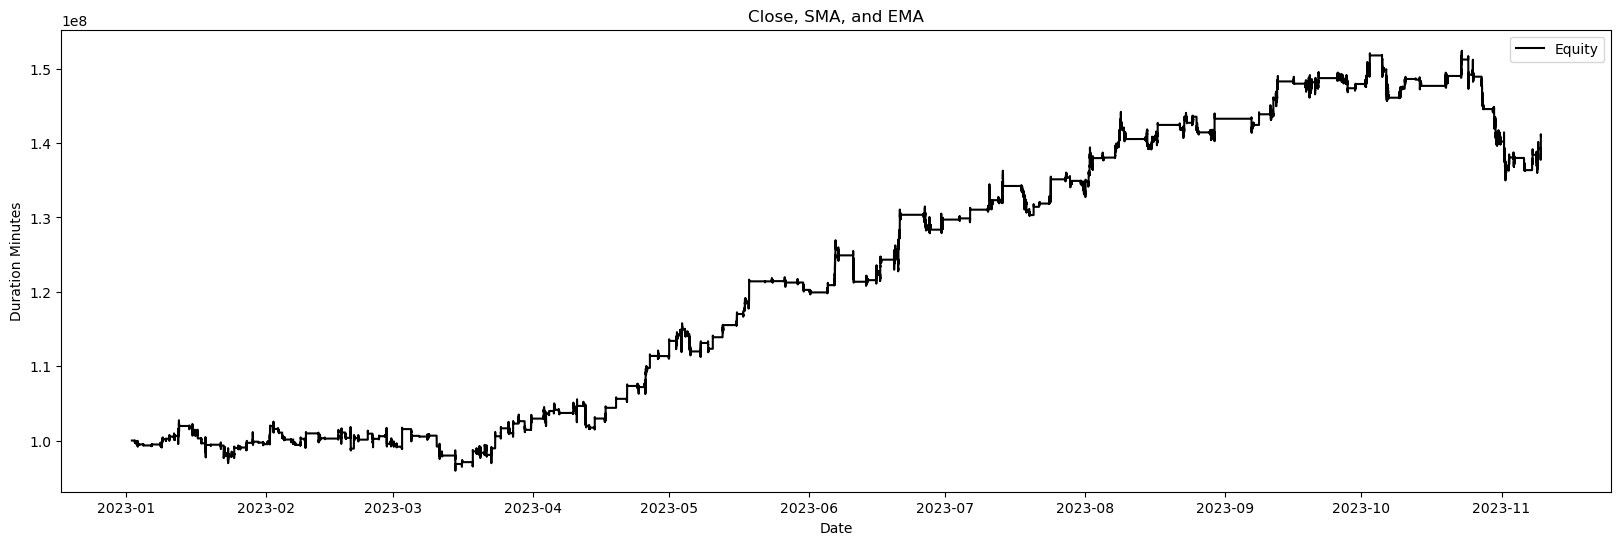

In [112]:
# Plot the Close, SMA, and EMA
eq_curve = stat['_equity_curve'] 

plt.figure(figsize=(20, 6))
plt.plot(eq_curve.index, eq_curve['Equity'], label='Equity', color = 'black')


# Set labels and title
plt.xlabel('Date')
plt.ylabel('Duration Minutes')
plt.title('Close, SMA, and EMA')
plt.legend()

In [119]:
#lets add our real trades to the dataframe 

trade_analysis = bt_data.copy()
trade_analysis['long_entries'] = None
trade_analysis['long_exits'] = None
trade_analysis['short_entries'] = None
trade_analysis['short_exits'] = None

for index, row in stat['_trades'].iterrows():
    if row['Size'] > 0:
        trade_analysis.at[row['EntryTime'], 'long_entries'] = row['EntryPrice']
        trade_analysis.at[row['ExitTime'], 'long_exits'] = row['ExitPrice']
    if row['Size'] < 0:
        trade_analysis.at[row['EntryTime'], 'short_entries'] = row['EntryPrice']
        trade_analysis.at[row['ExitTime'], 'short_exits'] = row['ExitPrice']

    


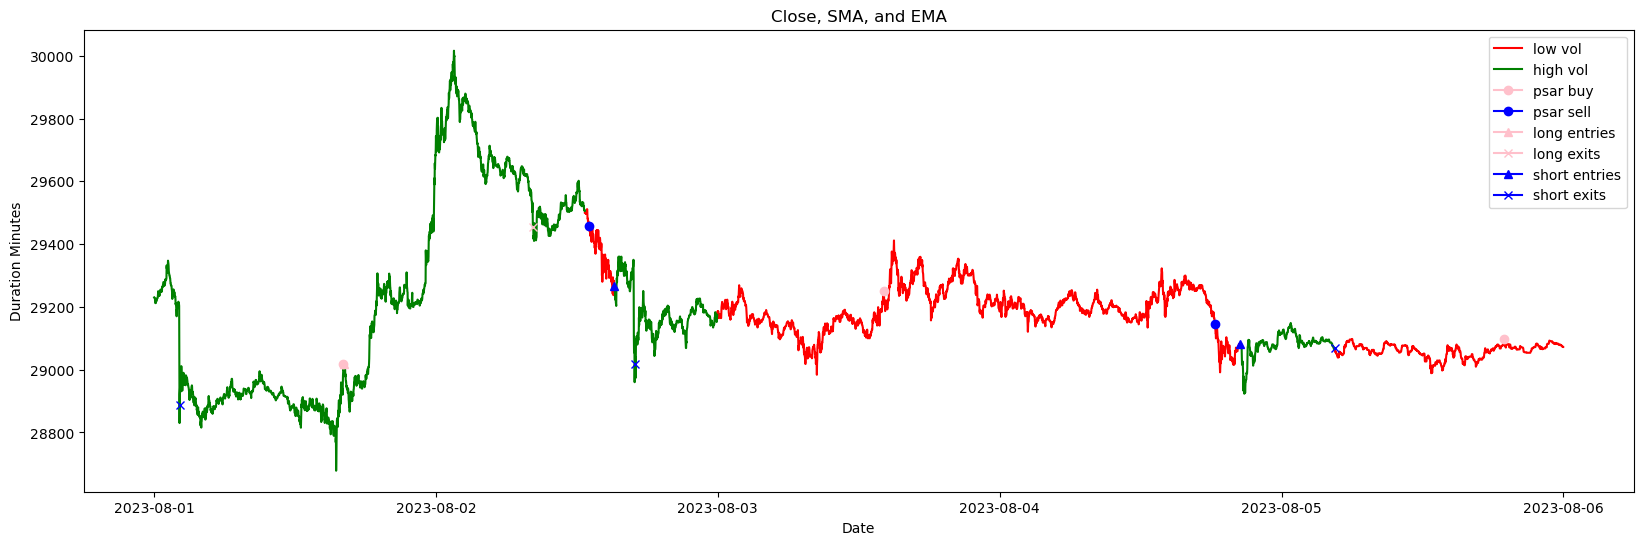

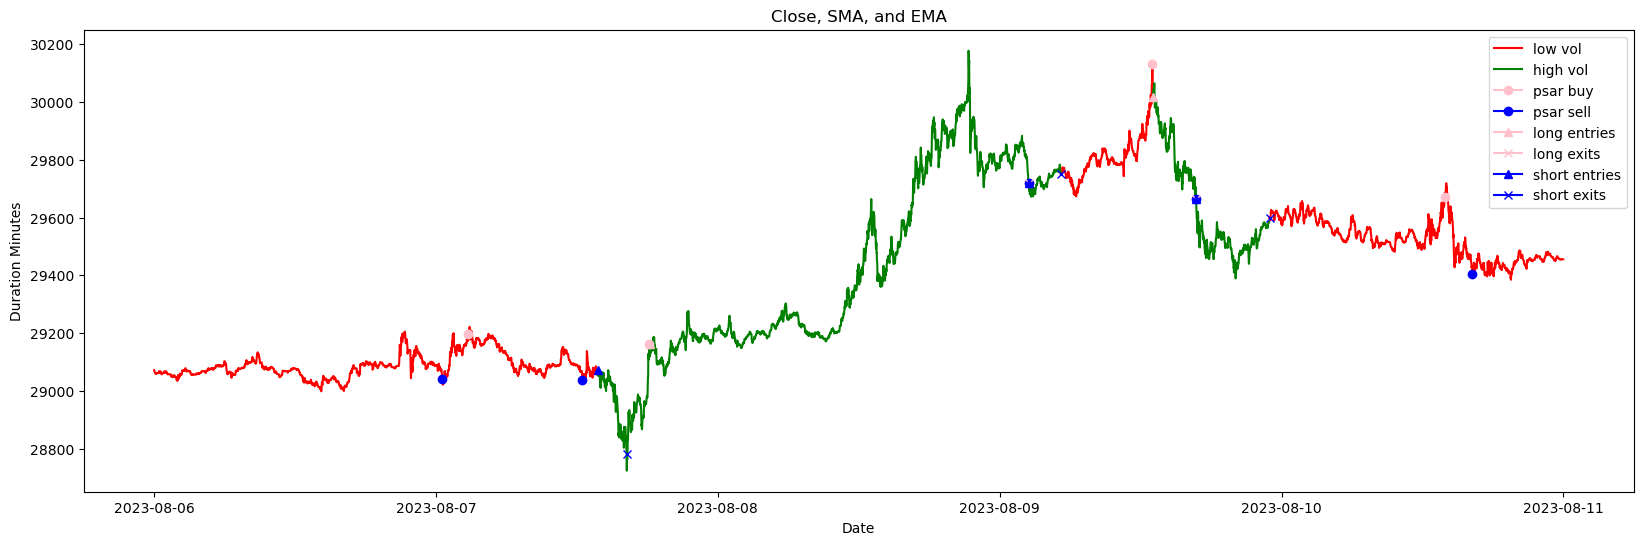

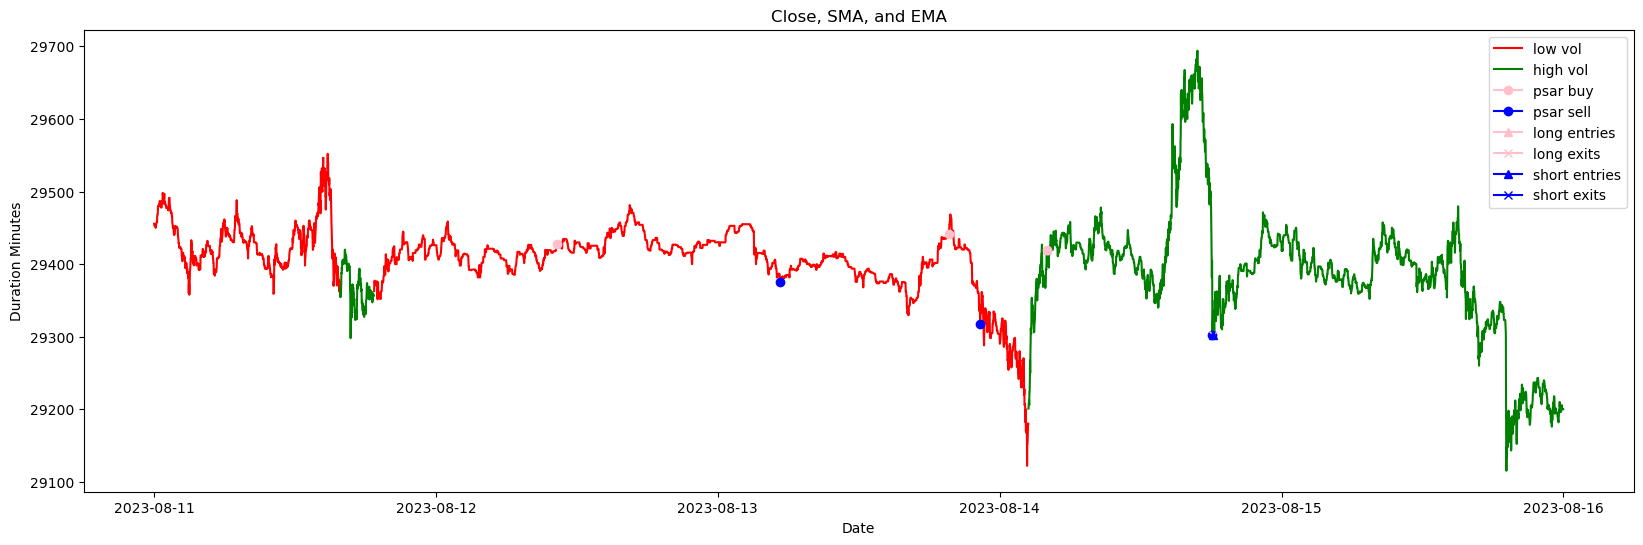

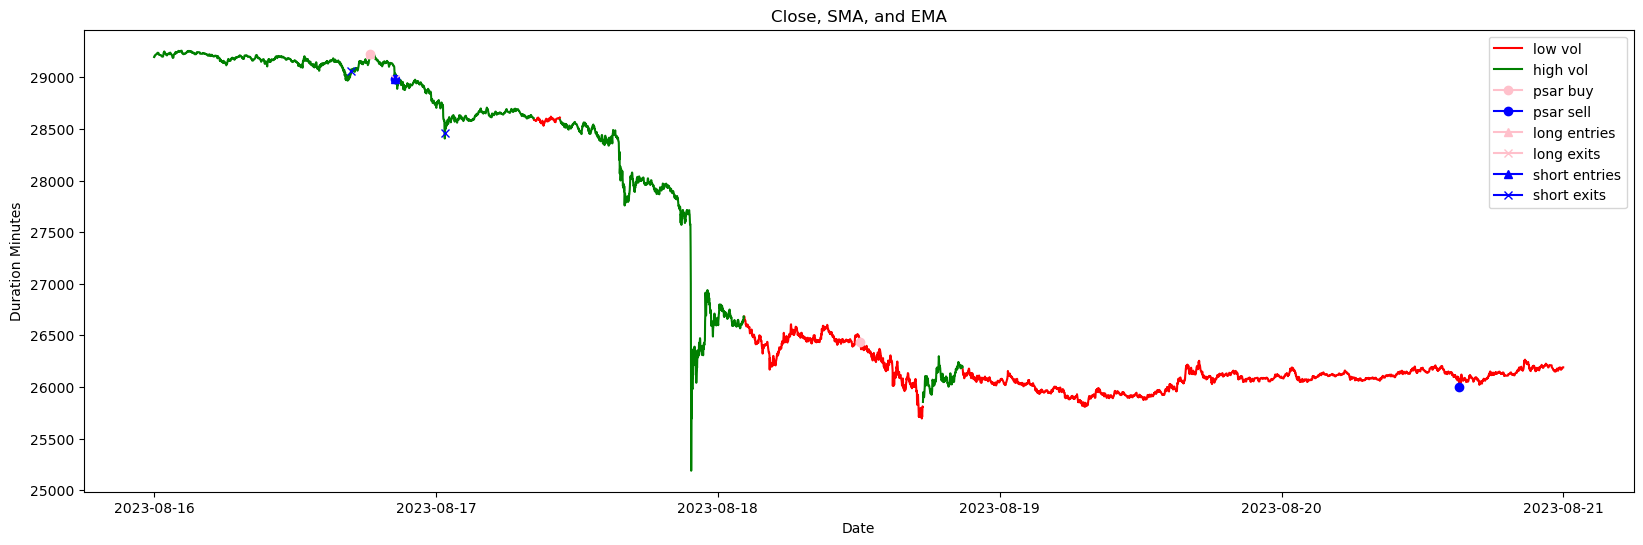

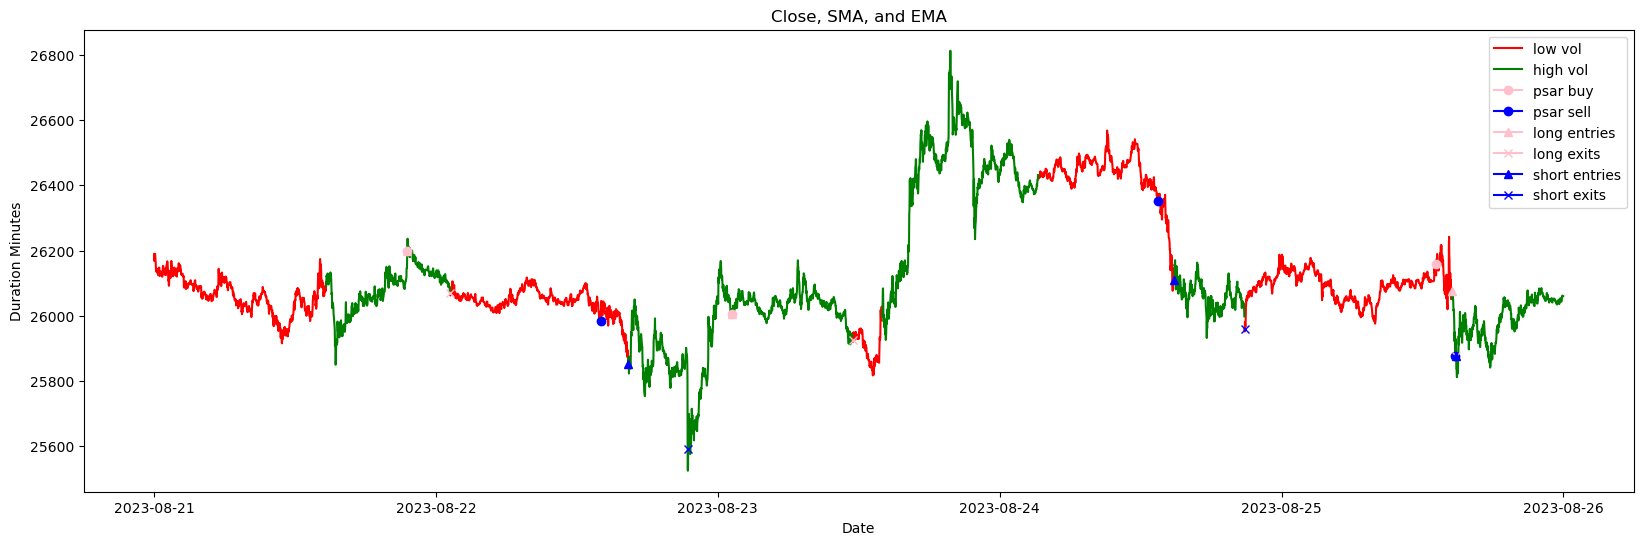

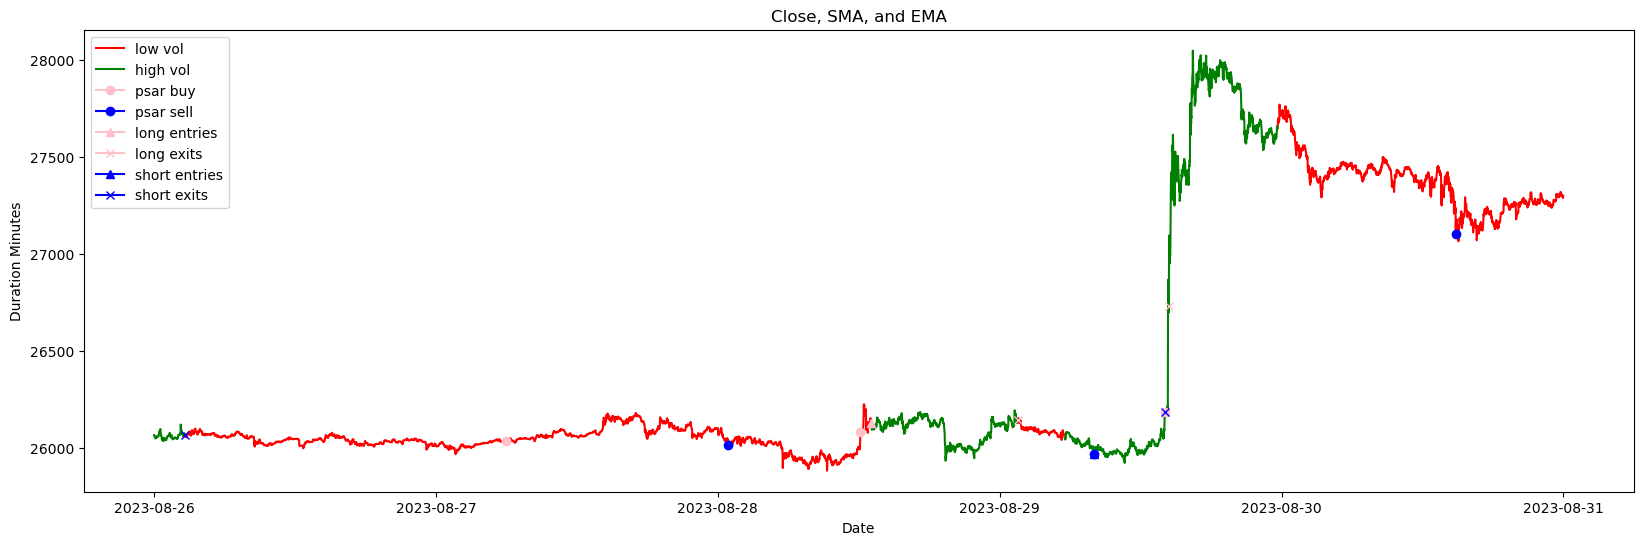

In [120]:
for i in range(6):
    start = f'2023-8-{(i*5)+1}'
    end = f'2023-8-{(i+1)*5}'

    plot_sample = trade_analysis.loc[start:end].copy()

    # print(plot_sample.to_markdown())
    


    plot_sample['bullish'] = np.where(plot_sample['cross'] == 1, None, plot_sample['Close'])
    plot_sample['bearish'] = np.where(plot_sample['cross'] == -1, None, plot_sample['Close'])

    plot_sample['psar buy'] = np.where(plot_sample['Signal'] != 1, None, plot_sample['Close'])
    plot_sample['psar sell'] = np.where(plot_sample['Signal'] != -1, None, plot_sample['Close'])

    # print(plot_sample.to_markdown())

    # Plot the Close, SMA, and EMA
    plt.figure(figsize=(20, 6))
    plt.plot(plot_sample.index, plot_sample['bearish'], label='low vol', color = 'red')
    plt.plot(plot_sample.index, plot_sample['bullish'], label='high vol', color = 'green')
    plt.plot(plot_sample.index, plot_sample['psar buy'], label = 'psar buy', marker = 'o', color = 'pink')
    plt.plot(plot_sample.index, plot_sample['psar sell'], label = 'psar sell', marker = 'o', color = 'blue')
    plt.plot(plot_sample.index, plot_sample['long_entries'], label = 'long entries', marker = '^', color = 'pink')
    plt.plot(plot_sample.index, plot_sample['long_exits'], label = 'long exits', marker = 'x', color = 'pink')
    plt.plot(plot_sample.index, plot_sample['short_entries'], label = 'short entries', marker = '^', color = 'blue')
    plt.plot(plot_sample.index, plot_sample['short_exits'], label = 'short exits', marker = 'x', color = 'blue')
    # plt.plot(plot_sample.index, plot_sample['Close'], label='close', linestyle='--', color = 'black')
    # plt.plot(plot_sample.index, plot_sample['sma'], label=f'SMA ({sma_window} periods)', linestyle='--', marker='o')
    # plt.plot(plot_sample.index, plot_sample['ema'], label=f'EMA (span={ema_span})', linestyle='--', marker='o')

    # Set labels and title
    plt.xlabel('Date')
    plt.ylabel('Duration Minutes')
    plt.title('Close, SMA, and EMA')
    plt.legend()

In [39]:
class Jumper(Strategy): 
    
    signal_threshold = datetime.timedelta(hours=3) # three hours for a high vol period to show
    latest_signal_time = None
    latest_signal = None
    
    def _signal(self):
        return self.data.Signal
    
    def _vol(self):
        return self.data.cross
    
    def init(self):
        super().init()
        self.signal = self.I(self._signal)
        self.vol = self.I(self._vol)
    
    def bars_since_first_trade(self):
        if len(self.trades) > 0:
            first_trade_entry_bar = self.trades[0].entry_bar
            bars_since_first_trade = len(self.data.Close) - first_trade_entry_bar
            return bars_since_first_trade
        else:
            return 0
    
    def set_signal(self):
        self.latest_signal_time = self.data.index[-1]
        self.latest_signal = self.signal

    def next(self):
        super().next()

        if self.signal != 0:
            self.set_signal()
        
        if self.latest_signal is not None:
            

            if self.position and self.vol == -1:
                self.position.close()

            
            if not self.position and self.vol == 1 and self.latest_signal_time + self.signal_threshold > self.data.index[-1] :
                if self.latest_signal == 1:
                    self.buy(size=.99)
                else:
                    self.sell(size=.99)
        
        

In [40]:
start = "2023-01-01"
end = "2024-01-01"

bt = Backtest(
    df.loc[start:end],
    Jumper,
    cash=100_000_000,
    trade_on_close=False,
    commission=0.0000,
    exclusive_orders=False,
    margin=1,  # Set this to 0.5 for 2x leverage, 0.25 for 4x leverage, 0.125 for 8x leverage, etc.
)

stat = bt.run()
print(stat)

Start                     2023-01-02 08:15...
End                       2023-11-09 17:12...
Duration                    311 days 08:57:00
Exposure Time [%]                   27.616877
Equity Final [$]                 103104945.65
Equity Peak [$]                  112504433.87
Return [%]                           3.104946
Buy & Hold Return [%]               116.42465
Return (Ann.) [%]                    3.888236
Volatility (Ann.) [%]               15.602402
Sharpe Ratio                         0.249208
Sortino Ratio                        0.369585
Calmar Ratio                         0.397941
Max. Drawdown [%]                    -9.77089
Avg. Drawdown [%]                   -0.698323
Max. Drawdown Duration      155 days 20:09:00
Avg. Drawdown Duration        2 days 20:46:00
# Trades                                  230
Win Rate [%]                        52.608696
Best Trade [%]                        3.50953
Worst Trade [%]                     -3.812852
Avg. Trade [%]                    